<a href="https://colab.research.google.com/github/mkorlyakova/segment-cityScape/blob/master/city_Scapes_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт и инсталяция необходимого окружения

Грузим модули

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image
import tensorflow as tf


# Это своя метрика на Tensorflow DICE COEFF (https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2#:~:text=3.-,Dice%20Coefficient%20(F1%20Score),of%20union%20in%20section%202).)

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


In [2]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

Загружаем картинки для сегментации (имена одинаковые): 

- /images/изображение.png - это сам кадр 
- /labels/изображение.png - это разметка

Грузим репозиторий из git c проектом

In [3]:
!git clone -l -s https://github.com/mkorlyakova/segment-cityScape.git 

fatal: destination path 'segment-cityScape' already exists and is not an empty directory.


Открываем архив (это зависит от архива)

тут по rar, поэтому грузим libarchive

In [4]:
# https://pypi.python.org/pypi/libarchive
!pip install rarfile
import rarfile

Раскрываем архив на виртуальной машине (картинок немного 100 шт.)

In [5]:
rf = rarfile.RarFile("/content/segment-cityScape/train.rar")
for f in rf.infolist():
    print(f.filename, f.file_size)
    if f.filename == "README":
        print(rf.read(f))
rf.extractall(   path = '/content/image/')

94.jpg 27255
95.jpg 31754
96.jpg 29809
97.jpg 33126
98.jpg 25346
99.jpg 26562
100.jpg 34325
1.jpg 32121
2.jpg 32120
3.jpg 27021
4.jpg 30514
5.jpg 30354
6.jpg 32087
7.jpg 26852
8.jpg 24037
9.jpg 31285
10.jpg 25278
11.jpg 33682
12.jpg 31378
13.jpg 31145
14.jpg 29888
15.jpg 35658
16.jpg 34303
17.jpg 32437
18.jpg 33157
19.jpg 30944
20.jpg 32573
21.jpg 29640
22.jpg 33211
23.jpg 27723
24.jpg 27376
25.jpg 24952
26.jpg 27165
27.jpg 30960
28.jpg 31672
29.jpg 30511
30.jpg 34505
31.jpg 25280
32.jpg 30295
33.jpg 28014
34.jpg 29445
35.jpg 30231
36.jpg 29695
37.jpg 30275
38.jpg 26711
39.jpg 22849
40.jpg 26001
41.jpg 28431
42.jpg 33661
43.jpg 32147
44.jpg 28746
45.jpg 30338
46.jpg 35004
47.jpg 29718
48.jpg 29360
49.jpg 36761
50.jpg 29506
51.jpg 31386
52.jpg 26888
53.jpg 30519
54.jpg 29282
55.jpg 27515
56.jpg 23308
57.jpg 22111
58.jpg 27752
59.jpg 26642
60.jpg 25302
61.jpg 33418
62.jpg 32341
63.jpg 29094
64.jpg 27657
65.jpg 30675
66.jpg 31565
67.jpg 30872
68.jpg 32116
69.jpg 27707
70.jpg 29551
71.jpg 

Проверяем, что архивы раскрылись

In [6]:
!ls

100.jpg  21.jpg  33.jpg  45.jpg  57.jpg  69.jpg  80.jpg  92.jpg
10.jpg	 22.jpg  34.jpg  46.jpg  58.jpg  6.jpg	 81.jpg  93.jpg
11.jpg	 23.jpg  35.jpg  47.jpg  59.jpg  70.jpg  82.jpg  94.jpg
12.jpg	 24.jpg  36.jpg  48.jpg  5.jpg	 71.jpg  83.jpg  95.jpg
13.jpg	 25.jpg  37.jpg  49.jpg  60.jpg  72.jpg  84.jpg  96.jpg
14.jpg	 26.jpg  38.jpg  4.jpg	 61.jpg  73.jpg  85.jpg  97.jpg
15.jpg	 27.jpg  39.jpg  50.jpg  62.jpg  74.jpg  86.jpg  98.jpg
16.jpg	 28.jpg  3.jpg	 51.jpg  63.jpg  75.jpg  87.jpg  99.jpg
17.jpg	 29.jpg  40.jpg  52.jpg  64.jpg  76.jpg  88.jpg  9.jpg
18.jpg	 2.jpg	 41.jpg  53.jpg  65.jpg  77.jpg  89.jpg  image
19.jpg	 30.jpg  42.jpg  54.jpg  66.jpg  78.jpg  8.jpg	 modelU.png
1.jpg	 31.jpg  43.jpg  55.jpg  67.jpg  79.jpg  90.jpg  sample_data
20.jpg	 32.jpg  44.jpg  56.jpg  68.jpg  7.jpg	 91.jpg  segment-cityScape


Прочитаем списки наших файлов (проверить идентичность, если имена одинаковые или собрать порядок чтения любым доступным способом)

In [7]:
import os, fnmatch
imag = os.listdir('/content/image/')


In [8]:
imag[:10]

['99.jpg',
 '100.jpg',
 '1.jpg',
 '57.jpg',
 '74.jpg',
 '46.jpg',
 '89.jpg',
 '85.jpg',
 '36.jpg',
 '63.jpg']

Задаю маршрут для чтения

In [9]:

PAHT_image = '/content/image/'
  

#Загружаем и делим картинки



In [49]:
images = []
segments = []
image_size = (200,600)
for i_name in imag:
  img = image.load_img(PAHT_image+i_name )
  img = image.img_to_array(img)
  image_=img[:,:img.shape[1]// 2,:]/255
  segment_=img[:,(img.shape[1] // 2):,:]
  images.append(image_)
  segments.append(segment_)


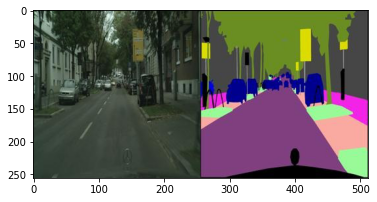

In [51]:
plt.imshow(img.astype(int))
plt.show()

Посмотрели на входные кадры

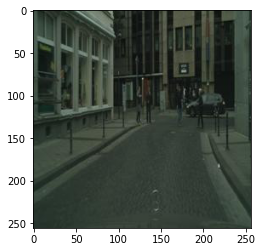

In [11]:
plt.imshow(images[0])
plt.show()

Посмотрим на цели

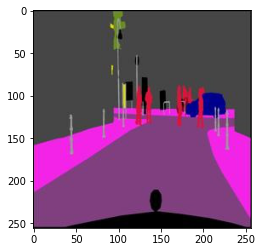

In [12]:
plt.imshow( segments[0]/255)
plt.show()

#Создаём обучающую выборку

Собираем входные примеры:

In [13]:
import cv2

In [14]:
rgb_vect=[]

for seg in segments:

  ind_x = np.random.randint(seg.shape[1],size=100)
  ind_y = np.random.randint(seg.shape[0],size=100)
  for i in range(100):
    rgb_vect.append(seg[ind_y[i],ind_x[i],:])
rgb_vect =  np.array(rgb_vect)    


In [15]:
rgb_vect.shape

(10000, 3)

In [16]:
from sklearn.cluster import DBSCAN

In [17]:
clast = DBSCAN(eps=0.5,min_samples=30,leaf_size=50)

cc= clast.fit(rgb_vect)

cc.labels_[:10]

array([ 0,  0,  0,  0,  0, -1,  0, -1,  1,  2])

In [18]:
clast.components_.shape

(4967, 3)

In [19]:
color_label = np.unique(clast.labels_)
color_label.shape

(22,)

In [20]:
from sklearn.cluster import KMeans

In [21]:
kmeans = KMeans(n_clusters=color_label.shape[0], random_state=0).fit(rgb_vect)

In [22]:
kmeans.cluster_centers_

array([[242.41154  ,  36.096577 , 231.28055  ],
       [ 70.225586 ,  69.878525 ,  70.08742  ],
       [127.74783  ,  63.248505 , 126.8701   ],
       [106.75043  , 141.51886  ,  33.99359  ],
       [  3.37648  ,   2.4549103,   4.192009 ],
       [  2.3325958,   1.2202835, 142.50154  ],
       [ 74.89996  , 128.45396  , 175.65752  ],
       [169.63885  , 146.85179  , 152.32408  ],
       [206.32349  ,  26.558846 ,  64.05883  ],
       [ 80.55495  ,   2.968666 ,  82.17278  ],
       [216.54684  , 207.49997  ,  32.421875 ],
       [160.58618  , 244.94827  , 157.25862  ],
       [172.98482  ,  53.621216 , 162.06061  ],
       [ 98.67961  , 103.33012  , 109.2136   ],
       [ 11.714264 ,  58.799995 , 100.14286  ],
       [125.32758  ,  33.913784 ,  44.431038 ],
       [215.72937  ,  59.258827 , 205.68234  ],
       [  9.676735 ,   3.9595566, 106.9394   ],
       [111.41174  , 135.11774  ,  63.28432  ],
       [ 40.426937 ,  30.134853 ,  40.39326  ],
       [ 79.69045  ,  84.603165 ,  37.26

In [23]:
color_label = np.unique(clast.labels_)
color_label.shape

(22,)

In [24]:

color_set=[]

for i in color_label[1:]:
  ind_r = np.where(kmeans.labels_ == i)[0]
  
  color_set.append(rgb_vect[ind_r[0]])

color_set = np.array(color_set)   


In [25]:
len(color_set.tolist())

21

Построим цвета , воспринимаемого диапазона для сегментированной картинки - это результат разметки, которую принес разметчик

Делаем конвертер в one-hot_encoding для выходных примеров

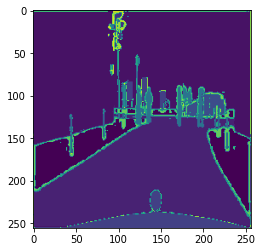

In [26]:
def Color2index(y,arr_col=[[0,0,0],[255,255,255]]):
  # y - входное rgb изображение для текущей легенды разметки
  y_p = labels = kmeans.predict(y.reshape((y.shape[0]*y.shape[1],3)))+1
  y_p = y_p.reshape((y.shape[0],y.shape[1]))
  y_ind = y_p
  y_cat = np.zeros(shape=(y.shape[0],y.shape[1],len(arr_col)+1))
  i=1
  for i_color in range(len(arr_col)):
    ind_i = np.where((y_p[:,:]==i_color))
    #print(ind_i)
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
 
  
  return y_cat, y_ind, i-1
  
# проверяем, как это отработало  
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]),color_set.tolist())
plt.imshow(ind_yi.astype(float)/h)
plt.show()  


In [27]:
color_set.tolist()

[[255.0, 26.0, 248.0],
 [70.0, 70.0, 70.0],
 [123.0, 66.0, 119.0],
 [109.0, 141.0, 34.0],
 [0.0, 0.0, 0.0],
 [0.0, 2.0, 137.0],
 [68.0, 128.0, 198.0],
 [145.0, 145.0, 145.0],
 [214.0, 19.0, 61.0],
 [66.0, 6.0, 66.0],
 [204.0, 219.0, 42.0],
 [154.0, 250.0, 152.0],
 [183.0, 34.0, 124.0],
 [98.0, 134.0, 96.0],
 [0.0, 62.0, 106.0],
 [129.0, 52.0, 60.0],
 [222.0, 51.0, 207.0],
 [12.0, 0.0, 116.0],
 [99.0, 113.0, 62.0],
 [49.0, 49.0, 49.0],
 [68.0, 78.0, 51.0]]

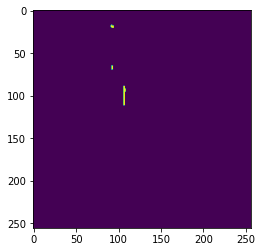

In [28]:
plt.imshow(cat_yi[:,:,11].astype(int))
plt.show()

In [29]:
cat_yi.shape

(256, 256, 22)

Сегментированную картинку в  One hot encoding (разметка на n классов)**

Делаем Аугментацию:

- изменяю яркость в прeделах 20% и строю по 10 случайных подкаров

In [52]:
# Строим тренировочный набор на кадрах исходной выборки
xTrain= []
yTrain = []

# test samples
N=20
for i in range(len(images)-N):
  # читаем исходный кадр и его разметку
  img  = images[i]
  seg = segments[i]
  # переводим разметку в ohe
  y_cat,_,_ = Color2index(image.img_to_array(seg),arr_col=color_set.tolist())
  x = image.img_to_array(img)
  
  # аугментация кадрированием и случайным изменением яркости  
  for k in range(2):
    x_br = image.img_to_array(image.apply_brightness_shift( img,np.random.rand(1)/5+0.8))
    
    xTrain.append(x_br)
    yTrain.append(y_cat)

xTrain = np.array(xTrain)
yTrain = np.array(yTrain)

# Строим тестовый набор на 2 кадрах исходной выборки
xTest = []
yTest = []

# читаем изображения тестового набора (20 последних)
for i in range(N):
  img  = images[-1-i]
  seg = segments[-1-i]
  y_cat,_,_ = Color2index(image.img_to_array(seg),arr_col=color_set.tolist())
  x = image.img_to_array(img)
 
  # аугментация кадрированием и сдвигом яркости
  for k in range(2):
    x_br = image.img_to_array(image.apply_brightness_shift( img,np.random.rand(1)/5+0.8))
    sx=np.random.randint(x.shape[1]-w)
    xTest.append(x_br)
    yTest.append(y_cat)

xTest = np.array(xTest)
yTest = np.array(yTest)

In [53]:
y_cat.shape

(256, 256, 22)

Размеры тренировочной части примеров

In [54]:
print(xTrain.shape)

(160, 256, 256, 3)


In [55]:
print(yTest.shape)

(40, 256, 256, 22)


Посмотрим , что получили по итогам конструирования выборки для тренировки

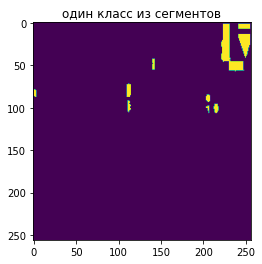

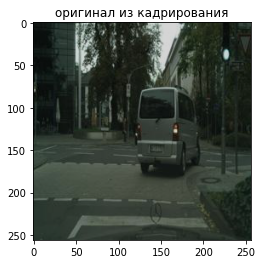

In [56]:
n = 10 # номер примера

# смотрим класс 0 - машинки
seg = yTrain[n][:,:,11]
img = xTrain[n]
plt.imshow(seg.astype(float))
plt.title('один класс из сегментов')
plt.show()
plt.imshow(img.astype(int))
plt.title('оригинал из кадрирования')
plt.show()

Смотрим на размер примеров для тестов и обучения

In [57]:
print('число примеров для тренировки: ',xTrain.shape[0])
print('число примеров для теста: ',xTest.shape[0])

число примеров для тренировки:  160
число примеров для теста:  40


#Создаём и обучаем U-net

Создадим сеть на основе претренированной модели VGG16 (Imagenet - там похожие по смыслу картинки при обучении)

In [58]:
from tensorflow.keras.utils import plot_model

**Претренированная  Unet**

Грузим VGG16 и определяем список слоев для работы :


- отделяю выход 13-го слоя, для работы в моей сети
- все слои замораживаю (все 18 слоев)
- от последнего рабочего слоя VGG16 (block4_conv3 (Conv2D)) ,буду надстраивать свою сеть
- при обучении используем размер тензоров (,200, 200, 3)(,200,200,14)
- после обучения перестраиваю сеть на размер (,200, 600, 3)(,200,600,14) . Это позволяет работать с любой картинкой нужного размера, а учить на меньших объектах, экономим память и время обработки, повышаем разнообразие в каждом пакекте (для медицинских фоток типа гистологий работает отлично, тут похуже).



In [37]:
 pre_trained_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")

Посмотрим на схему сети

In [38]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

Строим рабочую модель

In [59]:
def unet_pre_train(num_classes = 13, input_shape= (256, 256, 3)):  
    # грузим   VGG16
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    # замораживаем все слои
    for layer in pre_trained_model.layers[:18]:
      layer.trainable = False
    # фиксируем последний рабочий слой для своего потока  
    x = pre_trained_model.layers[13].output
    # фиксируем скипы для переноса из VGG16 (надо еще проверять)
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    #  фиксируем вход сети
    img_input = pre_trained_model.inputs

    # задаем список скипов 
    blocks = [block_4_out, block_3_out, block_2_out]
    #print(block_4_out)
    #print(block_3_out)
    #print(block_2_out)
    # UP 1
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)
    
    for i in [0,1,2]:
      x = concatenate([x, blocks[i]]) # добавили перенос из понижаюшего плеча VGG16
      x = Conv2D(256, (3, 3), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

      x = Conv2D(256, (3, 3), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      # UP i
      x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

    
    # последний слой сверток для классификации
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)
    # собираем модель 
    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    # вернем модель
    return model

Создаем модель для кадров 200х200

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________________________

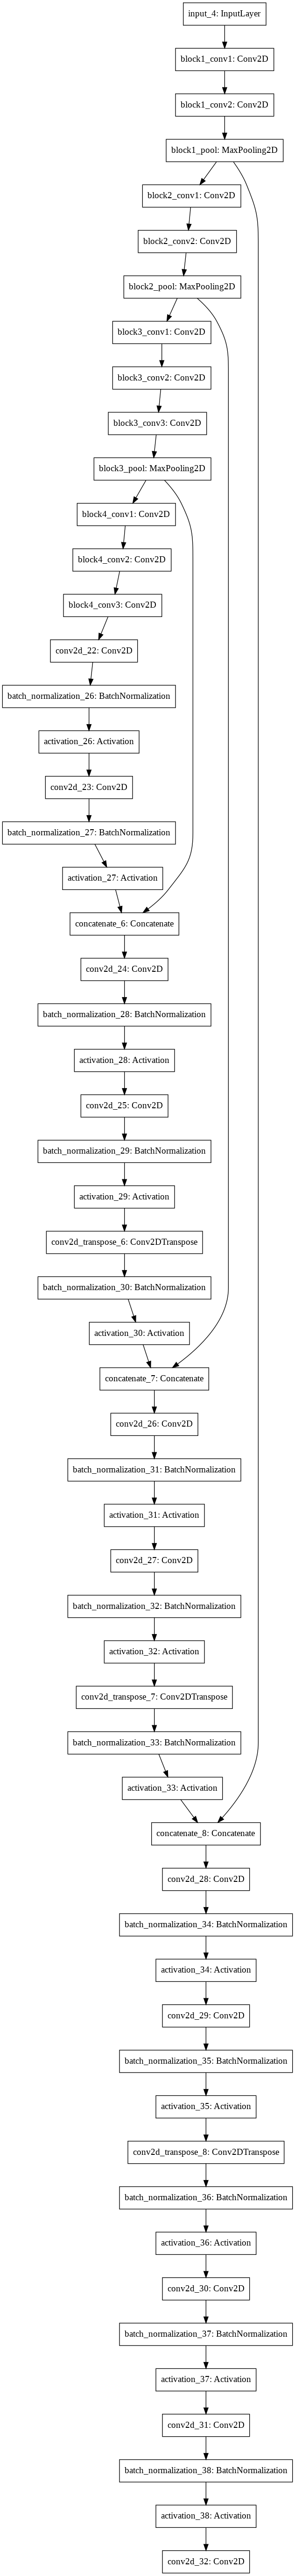

In [60]:
modelU = unet_pre_train(num_classes = yTrain.shape[3], input_shape= (256, 256, 3))

plot_model(modelU, to_file='modelU.png')

Обучаем по грубой схеме (шаг обучения в Adam по умолчанию) до 30 эпох

In [61]:
history = modelU.fit(xTrain, yTrain, epochs=30, batch_size=3, validation_data=(xTest, yTest))

Epoch 1/30
54/54 [==============================] - 33s 603ms/step - loss: 1.4627 - dice_coef: 0.4336 - val_loss: 4.8817 - val_dice_coef: 0.1270
Epoch 2/30
54/54 [==============================] - 32s 590ms/step - loss: 1.0164 - dice_coef: 0.5704 - val_loss: 1.6592 - val_dice_coef: 0.4585
Epoch 3/30
54/54 [==============================] - 32s 589ms/step - loss: 0.8740 - dice_coef: 0.6347 - val_loss: 1.2760 - val_dice_coef: 0.6697
Epoch 4/30
54/54 [==============================] - 32s 588ms/step - loss: 0.7937 - dice_coef: 0.6649 - val_loss: 1.4049 - val_dice_coef: 0.6072
Epoch 5/30
54/54 [==============================] - 32s 589ms/step - loss: 0.7167 - dice_coef: 0.6941 - val_loss: 1.5098 - val_dice_coef: 0.6327
Epoch 6/30
54/54 [==============================] - 32s 589ms/step - loss: 0.6685 - dice_coef: 0.7162 - val_loss: 1.1286 - val_dice_coef: 0.6516
Epoch 7/30
54/54 [==============================] - 32s 588ms/step - loss: 0.6488 - dice_coef: 0.7231 - val_loss: 1.0899 - val_dic

Визуализируем прогресс обучения 

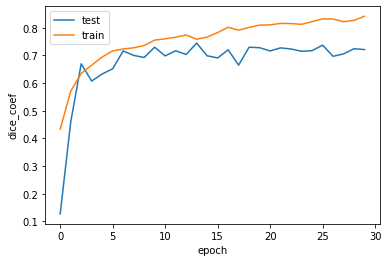

In [63]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

Сделаем более точное обучение (установим начальную скорость Adam 0.0001) и поставим ранний останов и контрольные точки модели 

In [ ]:
callback_ES = EarlyStopping(monitor='val_dice_coef',mode='max', patience=3)
callback_checkpoint = ModelCheckpoint( filepath='/content/cloned-repo', save_weights_only=True,
    monitor='val_dice_coef',  mode='max',  save_best_only=True)

In [ ]:

modelU.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',  metrics=[dice_coef])
history1 = modelU.fit(xTrain, yTrain, epochs=10, batch_size=3, validation_data=(xTest, yTest), callbacks=[callback_ES,callback_checkpoint])

Epoch 1/10
65/65 [==============================] - 16s 243ms/step - loss: 0.1976 - dice_coef: 0.8952 - val_loss: 0.1760 - val_dice_coef: 0.9064
Epoch 2/10
65/65 [==============================] - 15s 235ms/step - loss: 0.1904 - dice_coef: 0.8999 - val_loss: 0.1855 - val_dice_coef: 0.8997
Epoch 3/10
65/65 [==============================] - 16s 240ms/step - loss: 0.1856 - dice_coef: 0.9026 - val_loss: 0.1659 - val_dice_coef: 0.9102
Epoch 4/10
65/65 [==============================] - 16s 240ms/step - loss: 0.1732 - dice_coef: 0.9080 - val_loss: 0.1622 - val_dice_coef: 0.9113
Epoch 5/10
65/65 [==============================] - 16s 239ms/step - loss: 0.1741 - dice_coef: 0.9076 - val_loss: 0.1605 - val_dice_coef: 0.9113
Epoch 6/10
65/65 [==============================] - 15s 235ms/step - loss: 0.1688 - dice_coef: 0.9110 - val_loss: 0.1626 - val_dice_coef: 0.9094
Epoch 7/10
65/65 [==============================] - 16s 239ms/step - loss: 0.1658 - dice_coef: 0.9121 - val_loss: 0.1568 - val_dic

#Распознаём тестовую выборку

делаем предикт для примеров из тестов

In [64]:
predu = modelU.predict(xTest)
print(predu.shape)


(40, 256, 256, 22)


Отображаем эти примеры

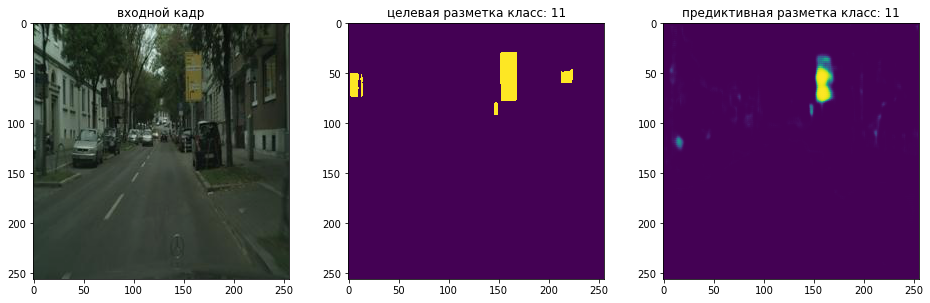

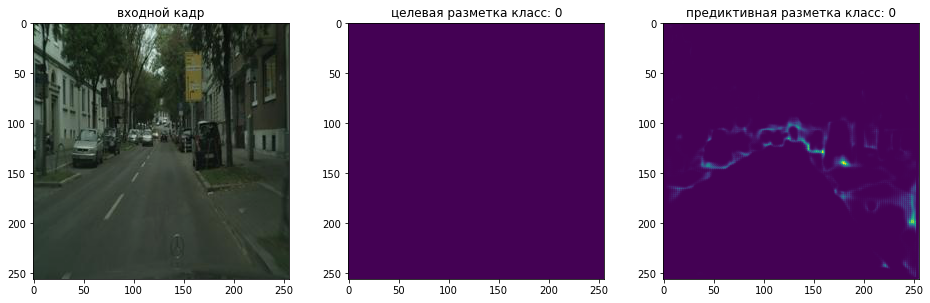

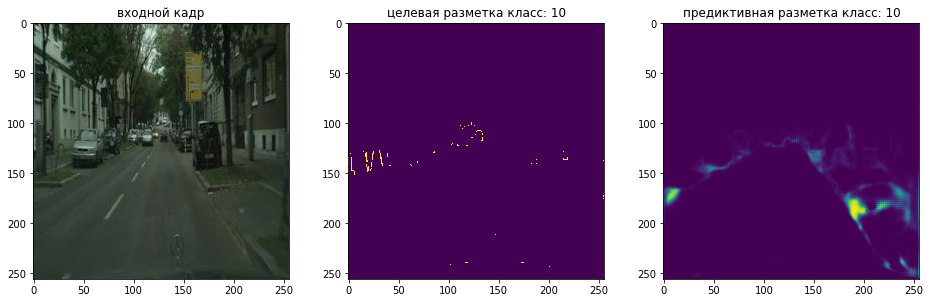

In [65]:
n = 1 # номер примера
class_ = 11 # индекс класса для отображения
plt.figure(figsize=(16,16))
plt.subplot(3,3,1)
plt.imshow(xTest[n,:,:,:].astype(int))
plt.title('входной кадр')

plt.subplot(3,3,2)
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.subplot(3,3,3)
img = predu[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
class_ = 0  # индекс класса для отображения
plt.figure(figsize=(16,16))
plt.subplot(3,3,4)
plt.imshow(xTest[n,:,:,:].astype(int))
plt.title('входной кадр')

plt.subplot(3,3,5)
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.subplot(3,3,6)
img = predu[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))

class_ = 10  # индекс класса для отображения
plt.figure(figsize=(16,16))
plt.subplot(3,3,7)
plt.imshow(xTest[n,:,:,:].astype(int))
plt.title('входной кадр')

plt.subplot(3,3,8)
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.subplot(3,3,9)
img = predu[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))

plt.show()


Сохраняем веса модели для построения большой модели.

In [ ]:
modelU.save_weights('modelU_weight.h5')

Обучим регрессию на прямом представлении картинки с разметкой 

- берем картинку разметки
- проводим масштабирование в [0,1] 
- сохраняем в yTrain_reg
- учим на xTrain, yTrain_reg
- тестим на xTest, yTest_reg

In [66]:
# Строим тренировочный набор на кадрах исходной выборки

yTrain_reg = []

# 
N=20 # test
for i in range(len(images)-N):
  # читаем исходный кадр и его разметку
  seg = segments[i]
  # переводим разметку в ohe
  y = image.img_to_array(seg)/255
  
  # аугментация кадрированием и случайным изменением яркости  
  for k in range(2):
    yTrain_reg.append(y)

yTrain_reg = np.array(yTrain_reg)

# Строим тестовый набор на 2 кадрах исходной выборки
yTest_reg = []

# читаем изображения тестового набора (20 последних)
for i in range(N):
  seg = segments[-1-i]
  
  y = image.img_to_array(seg)/255
 
  # аугментация кадрированием и сдвигом яркости
  for k in range(2):
   yTest_reg.append(y)

yTest_reg = np.array(yTest_reg)

Перестраиваю модель на регрессор

In [81]:
def unet_pre_train_reg(num_classes = 3, input_shape= (256, 256, 3)):  
    # грузим   VGG16
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    # замораживаем все слои
    for layer in pre_trained_model.layers[:18]:
      layer.trainable = False
    # фиксируем последний рабочий слой для своего потока  
    x = pre_trained_model.layers[13].output
    # фиксируем скипы для переноса из VGG16 (надо еще проверять)
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    #  фиксируем вход сети
    img_input = pre_trained_model.inputs

    # задаем список скипов 
    blocks = [block_4_out, block_3_out, block_2_out]
    #print(block_4_out)
    #print(block_3_out)
    #print(block_2_out)
    # UP 1
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)
    
    for i in [0,1,2]:
      x = concatenate([x, blocks[i]]) # добавили перенос из понижаюшего плеча VGG16
      x = Conv2D(16*2**(3-i), (3, 3), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

      x = Conv2D(16*2**(3-i), (3, 3), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      # UP i
      x = Conv2DTranspose(16*2**(3-i), (2, 2), strides=(2, 2), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

    
    # последний слой сверток для классификации
    #x = Conv2D(64, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)
    
    #x = Conv2D(64, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    # собираем модель 
    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='mse',
                  metrics=[dice_coef])
    model.summary()
    # вернем модель
    return model

modelU_big = unet_pre_train_reg(input_shape= (256, 256, 3))

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_10[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________

In [82]:
history = modelU_big.fit(xTrain, yTrain_reg, epochs=30, batch_size=3, validation_data=(xTest, yTest_reg))

Epoch 1/30
54/54 [==============================] - 10s 188ms/step - loss: 0.0386 - dice_coef: 0.3865 - val_loss: 0.0576 - val_dice_coef: 0.4067
Epoch 2/30
54/54 [==============================] - 9s 158ms/step - loss: 0.0249 - dice_coef: 0.4100 - val_loss: 0.0390 - val_dice_coef: 0.3906
Epoch 3/30
54/54 [==============================] - 9s 158ms/step - loss: 0.0219 - dice_coef: 0.4166 - val_loss: 0.0302 - val_dice_coef: 0.4121
Epoch 4/30
54/54 [==============================] - 8s 157ms/step - loss: 0.0192 - dice_coef: 0.4242 - val_loss: 0.0260 - val_dice_coef: 0.4118
Epoch 5/30
54/54 [==============================] - 8s 157ms/step - loss: 0.0179 - dice_coef: 0.4275 - val_loss: 0.0378 - val_dice_coef: 0.3564
Epoch 6/30
54/54 [==============================] - 8s 157ms/step - loss: 0.0162 - dice_coef: 0.4319 - val_loss: 0.0245 - val_dice_coef: 0.4402
Epoch 7/30
54/54 [==============================] - 8s 157ms/step - loss: 0.0149 - dice_coef: 0.4364 - val_loss: 0.0246 - val_dice_coef

# Проверка для модели на регрессию

делаем предсказание и визуализируем его

In [83]:
predu_big = modelU_big.predict(xTest)
print(predu_big.shape)

(40, 256, 256, 3)


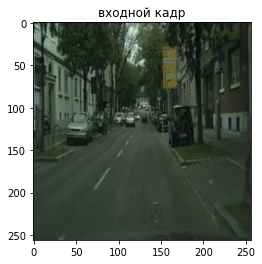

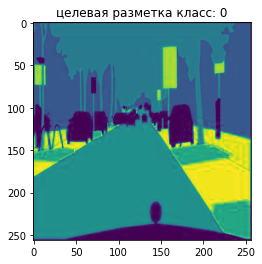

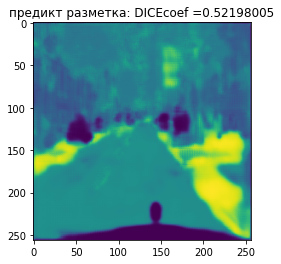

All samples DICE coeff =  0.44886595


In [86]:
n = 1 # номер примера для отображения (0 или 1))
class_ = 0 # индекс класса для отображения (от 0 до 2)


plt.imshow(xTest[n,:,:,:].astype(int))
plt.title('входной кадр')
plt.show()

img = yTest_reg[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()

img = predu_big[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предикт разметка: DICEcoef ='+str((dice_coef(K.constant(yTest_reg[n,:,:,class_]),K.constant(  predu_big[n,:,:,class_]))).numpy()))
plt.show()

print('All samples DICE coeff = ',dice_coef(K.constant(yTest_reg),K.constant(predu_big)).numpy())

Результат Распознавания новых картинок: DICE coeff =  0.45 по всем классам

Вышло прилично - имеет смысл поработать с глубиной и формой сети
